In [10]:
#Import libraries
library(ggplot2) # Data visualization
library(RSQLite)
library(dplyr)

#Connect to the database 
db <- dbConnect(SQLite(),"~/Downloads/soccer/database.sqlite")
Country <- dbGetQuery(db,"Select * from Country")
Match <- dbGetQuery(db,"Select * from Match")
League <- dbGetQuery(db,"Select * from League")
Team <- dbGetQuery(db,"Select * from Team")

#Count the number of matches the particular team played at home
home_match = count(Match,home_team_api_id)
away_match = count(Match,away_team_api_id)
#change names of the column n to number of matches
names(home_match)[names(home_match)=="n"] <- "home_matches_number"
names(away_match)[names(away_match)=="n"] <- "away_matches_number"

In [11]:
#Combine these two dataframes
new_match_data <- cbind(home_match,away_match)
#Add three new columns,
# a. total matches a particular team has played 
# b. how many matches the team has won at home and away
# c. what is the winning percentage. (wins/total_matches * 100)
new_match_data <- new_match_data %>% mutate(
    total_matches = home_matches_number + away_matches_number,
    wins = 0,
    win_percentage = 0,
    country = "",
    team_name = ""
)

#Find the country of the team and append in the country coloumn
for(row1 in rownames(new_match_data))
{
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(row1)])
    new_match_data$country[as.numeric(row1)] <- Country$name[Country$id==Match$country_id[as.numeric(home_indexes[1])]]
    new_match_data$team_name[as.numeric(row1)] <- Team$team_long_name[Team$team_api_id==new_match_data$home_team_api_id[as.numeric(row1)]]
}
#Drop the unnecessary columns "home_matches_number" and "away_matches_number"
drops_columns <- c("home_matches_number","away_matches_number")
new_match_data <- new_match_data[ , !(names(new_match_data) %in% drops_columns)]

print("Removed unnecessary columns")
print(head(new_match_data))

[1] "Removed unnecessary columns"
  home_team_api_id away_team_api_id total_matches wins win_percentage  country
1             1601             1601           240    0              0   Poland
2             1773             1773            90    0              0  Belgium
3             1957             1957           240    0              0   Poland
4             2033             2033           150    0              0 Portugal
5             2182             2182           240    0              0   Poland
6             2183             2183           150    0              0   Poland
              team_name
1          Ruch Chorzów
2   Oud-Heverlee Leuven
3 Jagiellonia Białystok
4        S.C. Olhanense
5           Lech Poznań
6           P. Warszawa


In [12]:
#Iterate over all the teams ids 
for(id in rownames(new_match_data))
{
    #win_count stores the number of wins if the current team has scored more goals than the opponent team.
    win_count = 0 
    #Find all the records in main "Match" table which match the current team id
    home_indexes = which(Match$home_team_api_id == new_match_data$home_team_api_id[as.numeric(id)])
    away_indexes = which(Match$away_team_api_id == new_match_data$away_team_api_id[as.numeric(id)])
    
    for(i in home_indexes)
    {
        if(Match$home_team_goal[i]>Match$away_team_goal[i])
        {
            win_count = win_count +1 
        }
    }
    for(i in away_indexes)
    {
        if(Match$away_team_goal[i]>Match$home_team_goal[i])
        {
            win_count = win_count + 1
        }
    }
    
    new_match_data$wins[as.numeric(id)] <- win_count
    new_match_data$win_percentage[as.numeric(id)] <- as.double(win_count/new_match_data$total_matches[as.numeric(id)]*100)
}

#Drop Away_team_id column and change home_team_api_id columns name to team_id
drop_columns <- c("away_team_api_id")
new_match_data <- new_match_data[ , !names(new_match_data) %in% drop_columns]
names(new_match_data)[names(new_match_data)=="home_team_api_id"]<-"team_id"

#Sort the teams based on the winning percentage
sorted_data <- new_match_data[order(-new_match_data$win_percentage),]
print(sorted_data[0:10,])

    team_id total_matches wins win_percentage     country        team_name
142    8634           304  234       76.97368       Spain     FC Barcelona
141    8633           304  228       75.00000       Spain   Real Madrid CF
175    9772           248  185       74.59677    Portugal       SL Benfica
176    9773           248  183       73.79032    Portugal         FC Porto
234    9925           304  218       71.71053    Scotland           Celtic
115    8548           152  108       71.05263    Scotland          Rangers
192    9823           272  193       70.95588     Germany FC Bayern Munich
132    8593           272  181       66.54412 Netherlands             Ajax
146    8640           272  178       65.44118 Netherlands              PSV
143    8635           212  136       64.15094     Belgium   RSC Anderlecht


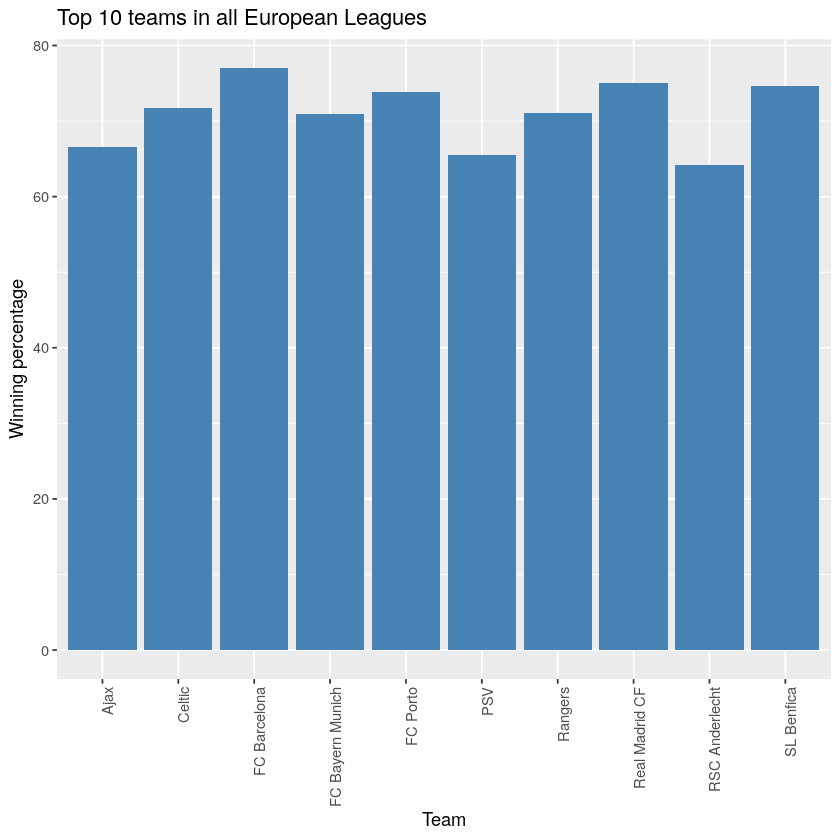

In [13]:
ggplot(data=sorted_data[0:10,], aes(x=team_name,y=win_percentage)) + 
geom_bar(stat="identity", fill="steelblue")+labs(x="Team",y="Winning percentage")+
ggtitle("Top 10 teams in all European Leagues")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

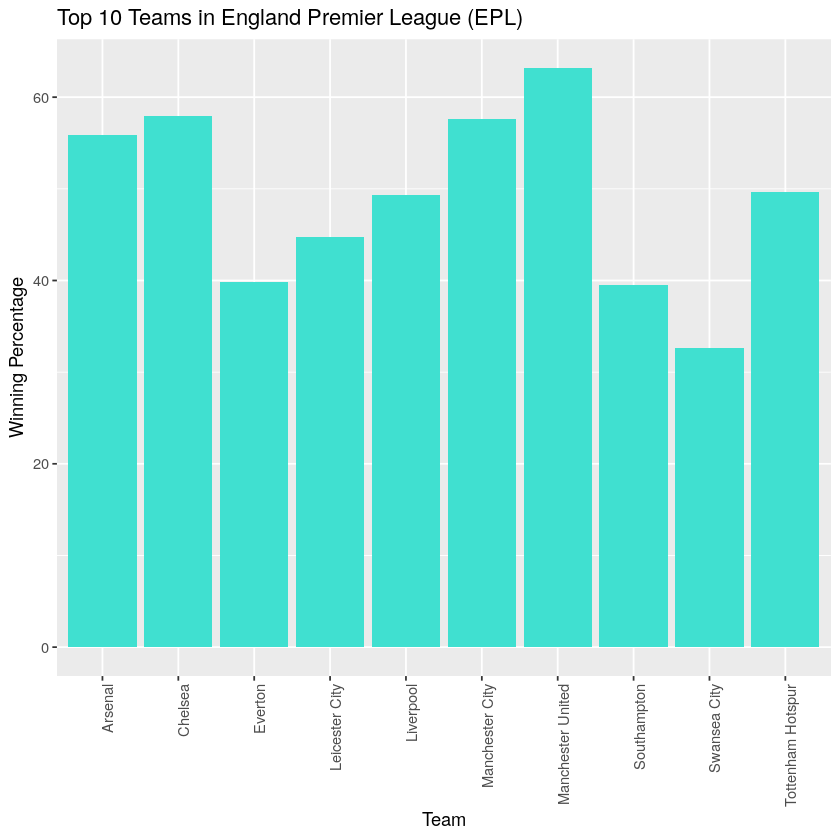

In [14]:
#Find Best teams in England's England Premier League
english_team <- sorted_data[sorted_data$country=="England",]
england <- english_team[order(-english_team$win_percentage),][1:10,]
ggplot(data=england,aes(x=team_name,y=win_percentage))+
geom_bar(stat="identity",fill="turquoise")+labs(x="Team",y="Winning Percentage")+
ggtitle("Top 10 Teams in England Premier League (EPL)")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

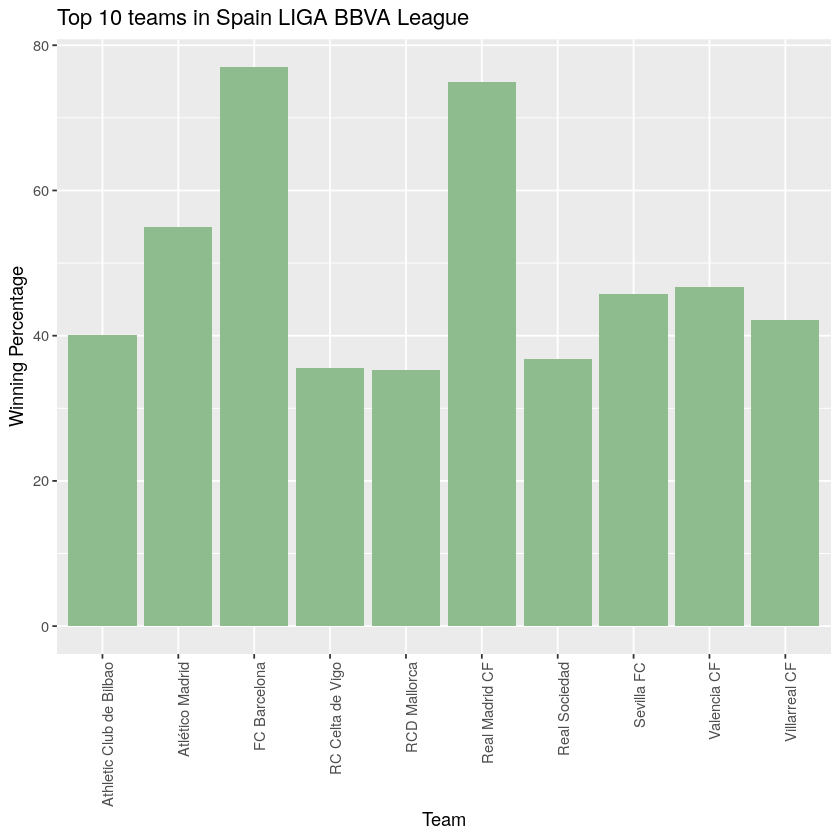

In [15]:


#Find the top teams from spain league 
spain_teams <- sorted_data[sorted_data$country=="Spain",]
spain <- spain_teams[order(-spain_teams$win_percentage),][1:10,]
ggplot(data=spain,aes(x=team_name,y=win_percentage))+
geom_bar(stat="identity",fill="darkseagreen")+labs(x="Team",y="Winning Percentage")+
ggtitle("Top 10 teams in Spain LIGA BBVA League")+theme(axis.text.x = element_text(angle = 90, hjust = 1))



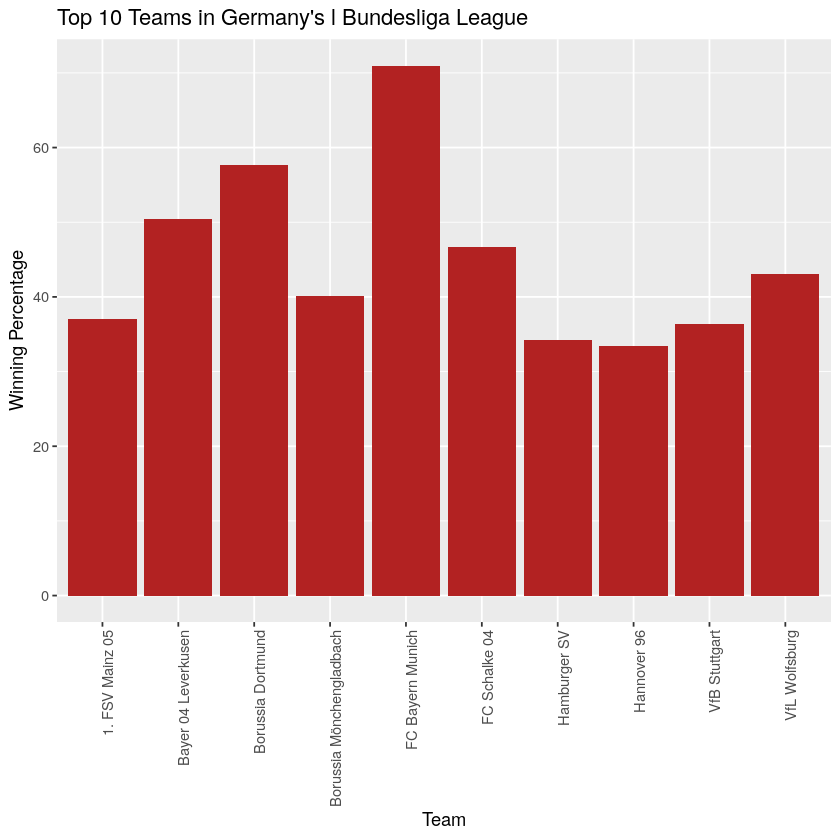

In [16]:
#Find top teams in Germany's l Bundesliga League
german_team <- sorted_data[sorted_data$country=="Germany",]
germany <- german_team[order(-german_team$win_percentage),][1:10,]
ggplot(data=germany,aes(x=team_name,y=win_percentage))+
geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Winning Percentage")+
ggtitle("Top 10 Teams in Germany's l Bundesliga League")+theme(axis.text.x = element_text(angle = 90, hjust = 1))

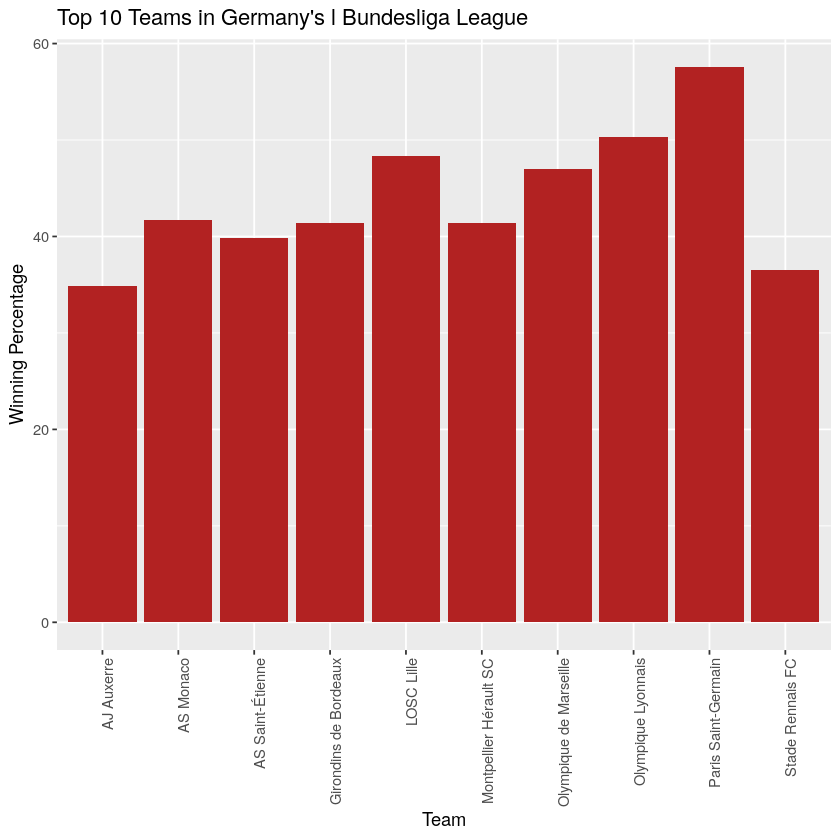

In [19]:
#Find top teams in Germany's l Bundesliga League
german_team <- sorted_data[sorted_data$country=="France",]
germany <- german_team[order(-german_team$win_percentage),][1:10,]
ggplot(data=germany,aes(x=team_name,y=win_percentage))+
geom_bar(stat='identity',fill="firebrick ")+labs(x="Team",y="Winning Percentage")+
ggtitle("Top 10 Teams in Germany's l Bundesliga League")+theme(axis.text.x = element_text(angle = 90, hjust = 1))